 # Charlotte Real Estate Market Analysis

 ## Predicting Housing Prices and Market Phases for Investment Timing



 **Team Members:** [Names]

 **Course:** Data Mining Final Project

 **Date:** November 2025



 ---

 ## 1. Introduction



 ### Problem Statement



 The Charlotte metropolitan area has experienced explosive growth over the past decade,

 making it one of the hottest real estate markets in the Southeast. For investors and

 homebuyers, timing the market correctly can mean the difference between significant

 gains and missed opportunities.



 **Our goal is to build a predictive system that answers three key questions:**



 1. **Price Prediction:** What will the median sale price be in a given zip code?

 2. **Market Phase Detection:** Is the current market HOT, COLD, or STABLE?

 3. **Trend Forecasting:** How will prices evolve over the next several quarters?



 ### Business Value



 This analysis provides actionable intelligence for:

 - **Real estate investors** deciding when to buy or sell properties

 - **Homebuyers** timing their purchase for optimal pricing

 - **Property managers** anticipating market shifts for portfolio optimization



 ### Approach



 We implement three parallel modeling tracks to address these questions:



 | Track | Model Type | Target Variable | Business Question |

 |-------|------------|-----------------|-------------------|

 | 1 | Regression | `log_price` | What will the price be? |

 | 2 | Classification | `market_phase` | Is it HOT/COLD/STABLE? |

 | 3 | LSTM Time Series | `median_sale_price` | Where is the trend heading? |

 ---

 ## 2. About the Data



 ### Data Source



 We use the **Redfin Housing Market Data** from Kaggle:

 - **URL:** https://www.kaggle.com/datasets/thuynyle/redfin-housing-market-data

 - **Original Size:** 6.6+ million rows across all US markets

 - **Filtered Size:** 11,765 rows (Charlotte metro area only)

 - **Time Period:** 2013-2021 (quarterly data)

 - **Geographic Scope:** 131 zip codes in NC and SC portions of Charlotte metro



 ### Why This Dataset?



 Redfin provides institutional-quality data that includes:

 - Actual transaction data (not just listings)

 - Pre-calculated momentum indicators (month-over-month, year-over-year)

 - Market velocity metrics (days on market, % sold above list)

 - Consistent quarterly reporting across all markets

In [48]:
# === SETUP AND IMPORTS ===
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import joblib
import json

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")


 ### Data Extraction



 The raw dataset contains all US markets. We filter to Charlotte metro area

 and select only "All Residential" property types to ensure consistency.

In [49]:
# === DATA LOADING AND FILTERING ===

# Fix malformed TSV (truncate to 58 columns)
!awk -F'\t' 'BEGIN {OFS="\t"} {NF=58; print}' zip_code_market_tracker.tsv000 > cleaned_data.tsv

# Load and filter to Charlotte metro
charlotte_df = pl.scan_csv("cleaned_data.tsv", separator="\t").filter(
    (pl.col("parent_metro_region") == 'Charlotte, NC') & 
    (pl.col("property_type") == 'All Residential')
)

# Select features for analysis
features_to_keep = [
    # Identifiers
    'period_begin', 'period_end', 'region', 'state_code',
    
    # Target variable
    'median_sale_price',
    
    # Core market indicators
    'median_list_price', 'median_ppsf',
    'homes_sold', 'inventory', 'new_listings', 'months_of_supply',
    'median_dom', 'pending_sales',
    'avg_sale_to_list', 'sold_above_list',
    'price_drops', 'off_market_in_two_weeks',
    
    # Pre-calculated trends
    'median_sale_price_mom', 'median_sale_price_yoy',
    'months_of_supply_mom', 'months_of_supply_yoy',
    'homes_sold_mom', 'homes_sold_yoy',
    'inventory_mom', 'inventory_yoy',
    'median_dom_mom', 'median_dom_yoy',
    'price_drops_mom', 'price_drops_yoy',
    'pending_sales_mom', 'pending_sales_yoy',
    'new_listings_mom', 'new_listings_yoy',
]

# Clean zip code format and save
charlotte_clean = charlotte_df.select(features_to_keep).with_columns(
    pl.col("region").str.replace_all("Zip Code: ", "")
)
charlotte_clean.collect().write_csv("charlotte_data.csv")

# Cleanup temp file
!rm cleaned_data.tsv

# Load into pandas for analysis
df = pd.read_csv("charlotte_data.csv")


 ### Dataset Overview



 After filtering, our dataset contains quarterly housing market data for the

 Charlotte metropolitan area spanning 9 years.

In [50]:
# === DATASET SUMMARY ===

# Add temporal features
dt = pd.to_datetime(df['period_begin'])
df['quarter'] = dt.dt.quarter
df['year'] = dt.dt.year
df['quarter_label'] = df['quarter'].map({1: 'Q1', 2: 'Q2', 3: 'Q3', 4: 'Q4'})
df['year_quarter'] = df['year'].astype(str) + '-' + df['quarter_label']

# Print summary
print("=" * 50)
print("DATASET SUMMARY")
print("=" * 50)
print(f"Total Records:    {df.shape[0]:,}")
print(f"Features:         {df.shape[1]}")
print(f"Date Range:       {df['period_begin'].min()} to {df['period_end'].max()}")
print(f"Years Covered:    {df['year'].min()} to {df['year'].max()}")
print(f"Zip Codes:        {df['region'].nunique()}")
print(f"States:           {df['state_code'].unique().tolist()}")


DATASET SUMMARY
Total Records:    11,765
Features:         37
Date Range:       2013-02-01 to 2021-12-31
Years Covered:    2013 to 2021
Zip Codes:        131
States:           ['SC', 'NC']


 ### Feature Descriptions



 Our features fall into four categories:



 | Category | Features | Description |

 |----------|----------|-------------|

 | **Price Metrics** | `median_sale_price`, `median_list_price`, `median_ppsf` | What properties cost |

 | **Supply/Demand** | `homes_sold`, `inventory`, `new_listings`, `months_of_supply` | Market liquidity |

 | **Market Velocity** | `median_dom`, `sold_above_list`, `off_market_in_two_weeks` | How fast homes sell |

 | **Momentum** | `*_mom`, `*_yoy` | Month-over-month and year-over-year changes |

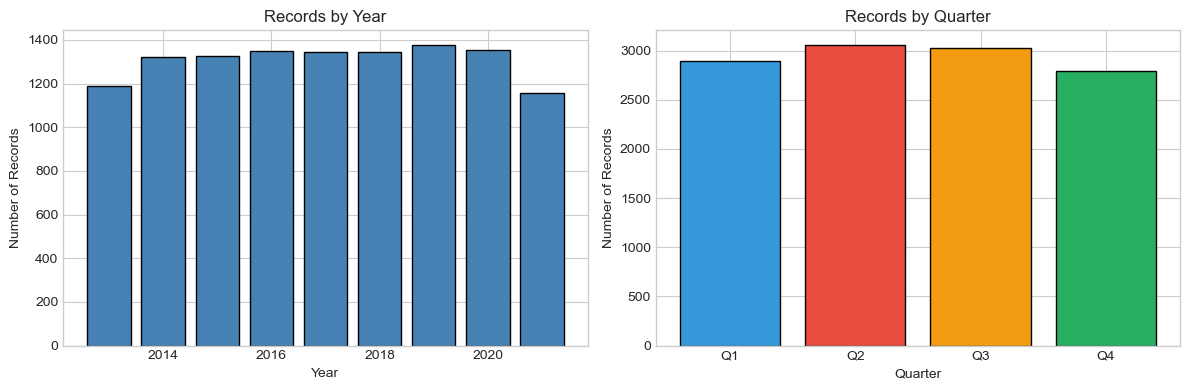


Year distribution:
year
2013    1191
2014    1320
2015    1328
2016    1348
2017    1347
2018    1345
2019    1375
2020    1356
2021    1155
Name: count, dtype: int64

Quarter distribution:
quarter
1    2894
2    3053
3    3029
4    2789
Name: count, dtype: int64


In [51]:
# === YEAR AND QUARTER DISTRIBUTION ===

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Records by year
year_counts = df['year'].value_counts().sort_index()
axes[0].bar(year_counts.index, year_counts.values, color='steelblue', edgecolor='black')
axes[0].set_title('Records by Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Records')

# Records by quarter
quarter_counts = df['quarter'].value_counts().sort_index()
axes[1].bar(['Q1', 'Q2', 'Q3', 'Q4'], quarter_counts.values, 
            color=['#3498db', '#e74c3c', '#f39c12', '#27ae60'], edgecolor='black')
axes[1].set_title('Records by Quarter')
axes[1].set_xlabel('Quarter')
axes[1].set_ylabel('Number of Records')

plt.tight_layout()
plt.show()

print(f"\nYear distribution:\n{year_counts}")
print(f"\nQuarter distribution:\n{quarter_counts}")


 ---

 ## 3. Exploratory Data Analysis



 Before modeling, we need to understand our data's characteristics, identify

 issues requiring cleaning, and discover patterns that inform feature engineering.

 ### 3.1 Missing Data Analysis



 Real-world datasets invariably have missing values. Understanding the pattern

 of missingness helps us choose appropriate imputation strategies.

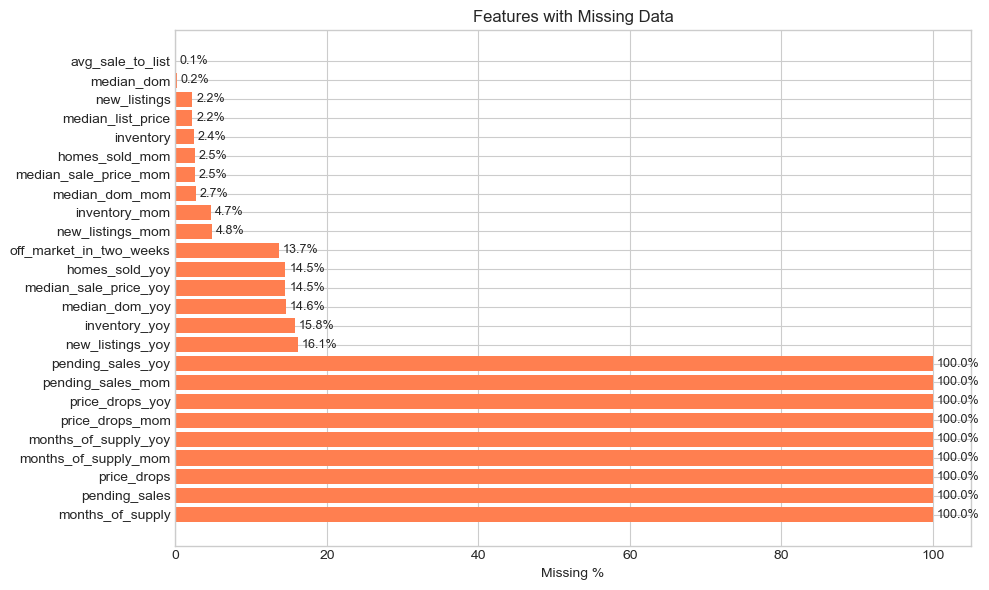

Features with 100% missing: 9
Features with partial missing: 16
Features with no missing: 12


In [52]:
# === MISSING DATA VISUALIZATION ===

missing_pct = [(col, df[col].isna().sum() / len(df) * 100) for col in df.columns]
missing_pct = sorted(missing_pct, key=lambda x: x[1], reverse=True)

# Only show features with missing data
missing_with_values = [(col, pct) for col, pct in missing_pct if pct > 0]

if missing_with_values:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh([x[0] for x in missing_with_values], [x[1] for x in missing_with_values], color='coral')
    for i, (col, pct) in enumerate(missing_with_values):
        ax.text(pct + 0.5, i, f"{pct:.1f}%", va='center', fontsize=9)
    ax.set_xlabel('Missing %')
    ax.set_title('Features with Missing Data')
    plt.tight_layout()
    plt.show()

print(f"Features with 100% missing: {sum(1 for _, pct in missing_pct if pct == 100)}")
print(f"Features with partial missing: {sum(1 for _, pct in missing_pct if 0 < pct < 100)}")
print(f"Features with no missing: {sum(1 for _, pct in missing_pct if pct == 0)}")


 ### 3.2 Data Cleaning Strategy



 Based on the missing data analysis, we apply the following cleaning strategy:



 1. **Drop 100% empty columns** - These provide no information

 2. **Fill YoY columns with 0** - First year has no prior year for comparison

 3. **Forward-fill within zip codes** - Use last known value for continuity

 4. **Median fill for remaining gaps** - Conservative estimate for isolated missing values

In [53]:
# === DATA CLEANING ===

# Step 1: Drop columns that are entirely empty
empty_columns = [
    'months_of_supply', 'pending_sales', 'price_drops',
    'months_of_supply_mom', 'months_of_supply_yoy',
    'price_drops_mom', 'price_drops_yoy',
    'pending_sales_mom', 'pending_sales_yoy',
]
df = df.drop(columns=empty_columns)
print(f"Step 1: Dropped {len(empty_columns)} empty columns")

# Step 2: Fill year-over-year columns with 0 (no change in first year)
yoy_columns = [
    'median_sale_price_yoy', 'homes_sold_yoy', 'inventory_yoy',
    'median_dom_yoy', 'new_listings_yoy',
]
for col in yoy_columns:
    df[col] = df[col].fillna(0)
print(f"Step 2: Filled {len(yoy_columns)} YoY columns with 0")

# Step 3: Fill off_market_in_two_weeks with median
median_omtw = df['off_market_in_two_weeks'].median()
df['off_market_in_two_weeks'] = df['off_market_in_two_weeks'].fillna(median_omtw)

# Step 4: Forward-fill + backward-fill within zip codes, then global median
small_missing = [
    'new_listings', 'median_list_price', 'inventory',
    'homes_sold_mom', 'median_sale_price_mom', 'median_dom_mom',
    'inventory_mom', 'new_listings_mom',
]

df = df.sort_values(['region', 'period_begin'])
for col in small_missing:
    df[col] = df.groupby('region')[col].ffill()
    df[col] = df.groupby('region')[col].bfill()
    df[col] = df[col].fillna(df[col].median())
print(f"Step 4: Forward/backward filled {len(small_missing)} columns by zip code")

# Step 5: Fill any remaining with median
df['median_dom'] = df['median_dom'].fillna(df['median_dom'].median())
df['avg_sale_to_list'] = df['avg_sale_to_list'].fillna(df['avg_sale_to_list'].median())

# Verify
total_missing = df.isna().sum().sum()
print(f"\n✅ Data cleaning complete. Remaining missing values: {total_missing}")


Step 1: Dropped 9 empty columns
Step 2: Filled 5 YoY columns with 0
Step 4: Forward/backward filled 8 columns by zip code

✅ Data cleaning complete. Remaining missing values: 0


 ### 3.3 Target Variable Analysis



 Our primary target variable is `median_sale_price`. Understanding its distribution

 is critical for choosing appropriate models and transformations.

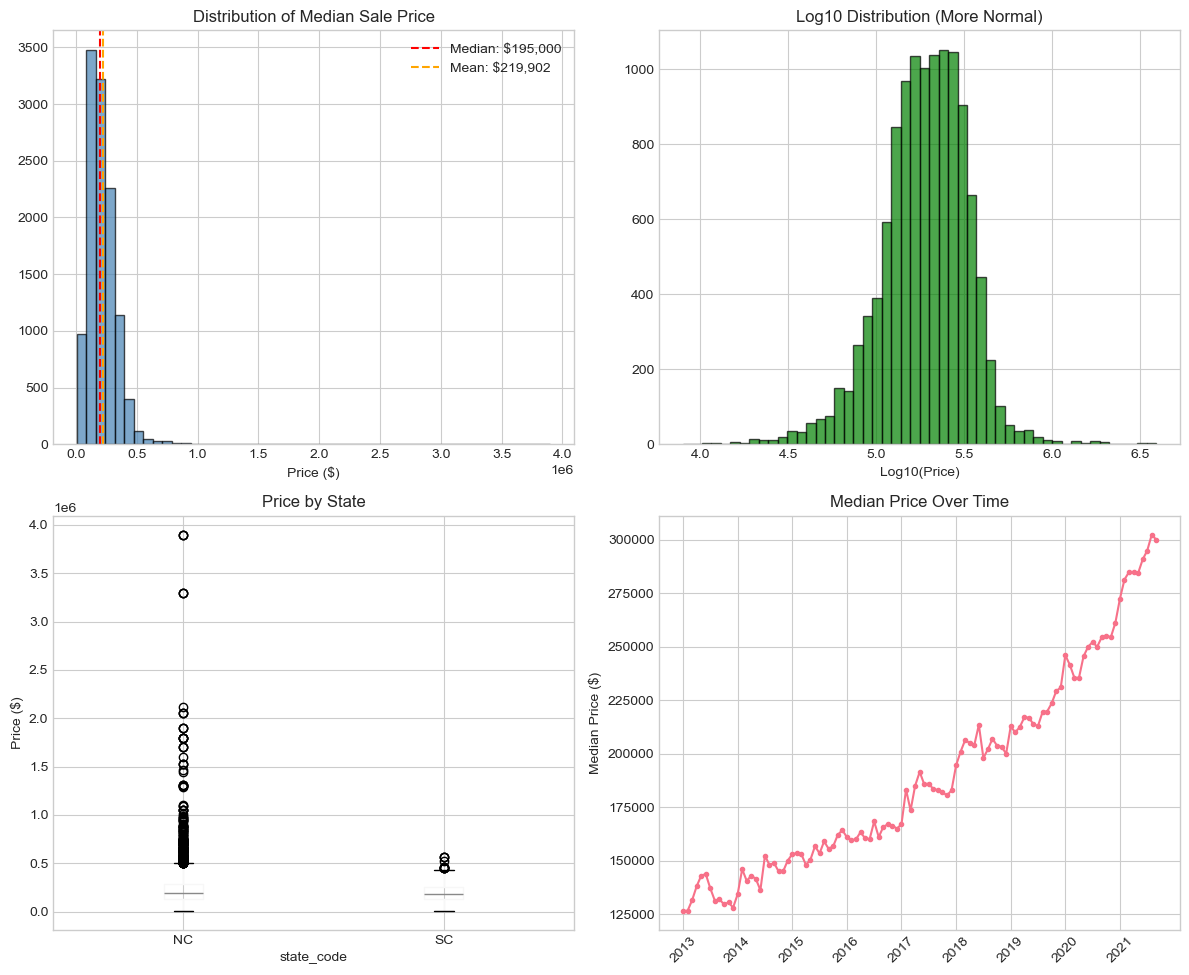


Target Variable Summary:
count       $11,765
mean       $219,902
std        $155,121
min          $8,000
25%        $135,000
50%        $195,000
75%        $275,050
max      $3,900,000
Name: median_sale_price, dtype: object


In [54]:
# === TARGET VARIABLE DISTRIBUTION ===

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Distribution (raw)
axes[0,0].hist(df['median_sale_price'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0,0].axvline(df['median_sale_price'].median(), color='red', linestyle='--', 
                   label=f"Median: ${df['median_sale_price'].median():,.0f}")
axes[0,0].axvline(df['median_sale_price'].mean(), color='orange', linestyle='--',
                   label=f"Mean: ${df['median_sale_price'].mean():,.0f}")
axes[0,0].set_title('Distribution of Median Sale Price')
axes[0,0].set_xlabel('Price ($)')
axes[0,0].legend()

# Distribution (log-transformed)
axes[0,1].hist(np.log10(df['median_sale_price']), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0,1].set_title('Log10 Distribution (More Normal)')
axes[0,1].set_xlabel('Log10(Price)')

# By state
df.boxplot(column='median_sale_price', by='state_code', ax=axes[1,0])
axes[1,0].set_title('Price by State')
axes[1,0].set_ylabel('Price ($)')
plt.suptitle('')

# Over time
time_trend = df.groupby('period_begin')['median_sale_price'].median().reset_index()
axes[1,1].plot(range(len(time_trend)), time_trend['median_sale_price'], marker='o', markersize=3)
axes[1,1].set_title('Median Price Over Time')
axes[1,1].set_ylabel('Median Price ($)')
year_positions = [i for i, date in enumerate(time_trend['period_begin']) if date.endswith('02-01')]
year_labels = [date[:4] for date in time_trend['period_begin'] if date.endswith('02-01')]
axes[1,1].set_xticks(year_positions)
axes[1,1].set_xticklabels(year_labels, rotation=45)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nTarget Variable Summary:")
print(df['median_sale_price'].describe().apply(lambda x: f"${x:,.0f}" if x > 100 else f"{x:.2f}"))


 **Key Observation:** The price distribution is right-skewed (mean > median), with

 a long tail of luxury properties. We will apply a **log transformation** to

 normalize this distribution for regression modeling.

 ### 3.4 Temporal Trends



 Real estate markets exhibit both long-term trends and seasonal patterns.

 Understanding these is essential for proper model design.

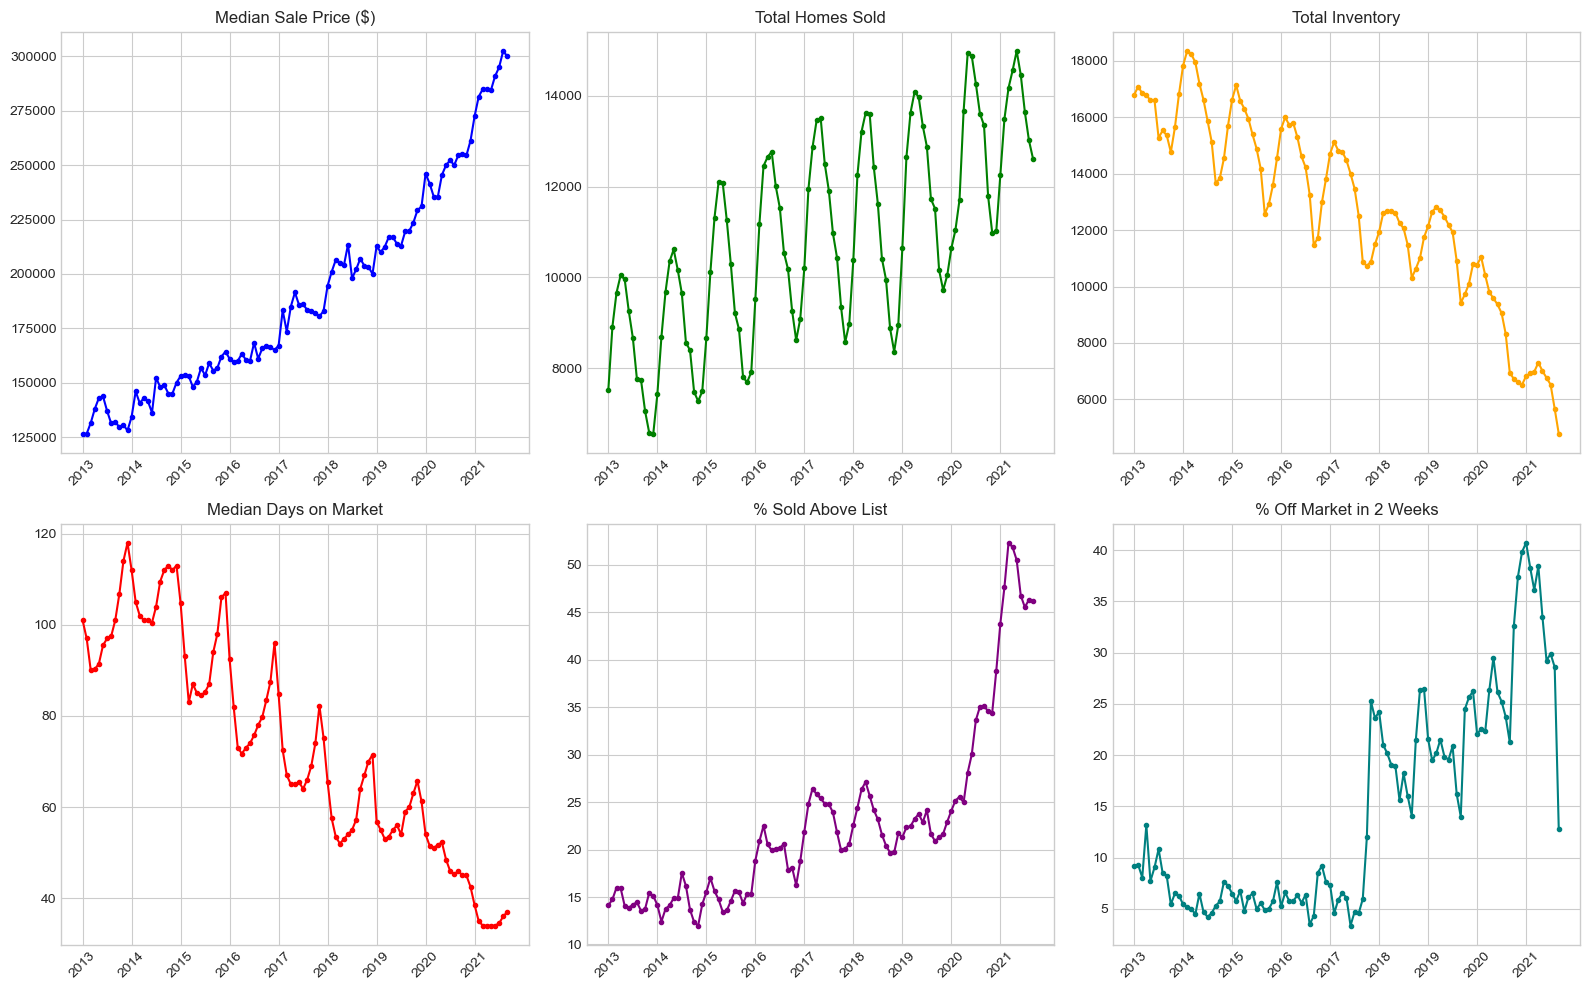

In [55]:
# === TEMPORAL ANALYSIS ===

quarterly = df.groupby('period_begin').agg({
    'median_sale_price': 'median',
    'homes_sold': 'sum',
    'inventory': 'sum',
    'median_dom': 'median',
    'sold_above_list': 'mean',
    'off_market_in_two_weeks': 'mean'
}).reset_index()

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

metrics = [
    ('median_sale_price', 'Median Sale Price ($)', 'blue'),
    ('homes_sold', 'Total Homes Sold', 'green'),
    ('inventory', 'Total Inventory', 'orange'),
    ('median_dom', 'Median Days on Market', 'red'),
    ('sold_above_list', '% Sold Above List', 'purple'),
    ('off_market_in_two_weeks', '% Off Market in 2 Weeks', 'teal')
]

for ax, (col, title, color) in zip(axes.flat, metrics):
    y_vals = quarterly[col] * 100 if 'sold_above' in col or 'off_market' in col else quarterly[col]
    ax.plot(range(len(quarterly)), y_vals, marker='o', markersize=3, color=color)
    ax.set_title(title)
    ax.set_xticks(year_positions)
    ax.set_xticklabels(year_labels, rotation=45)

plt.tight_layout()
plt.show()


 **Key Observations:**

 - **Prices** show consistent upward trend, accelerating sharply in 2020-2021

 - **Inventory** collapsed during COVID, creating supply shortage

 - **Days on Market** dropped dramatically, indicating seller's market

 - **% Sold Above List** surged from ~10% to 40%+, showing intense competition

 ### 3.5 Seasonality Analysis



 Real estate markets have well-known seasonal patterns. Spring/Summer typically

 see higher activity due to school schedules and weather.

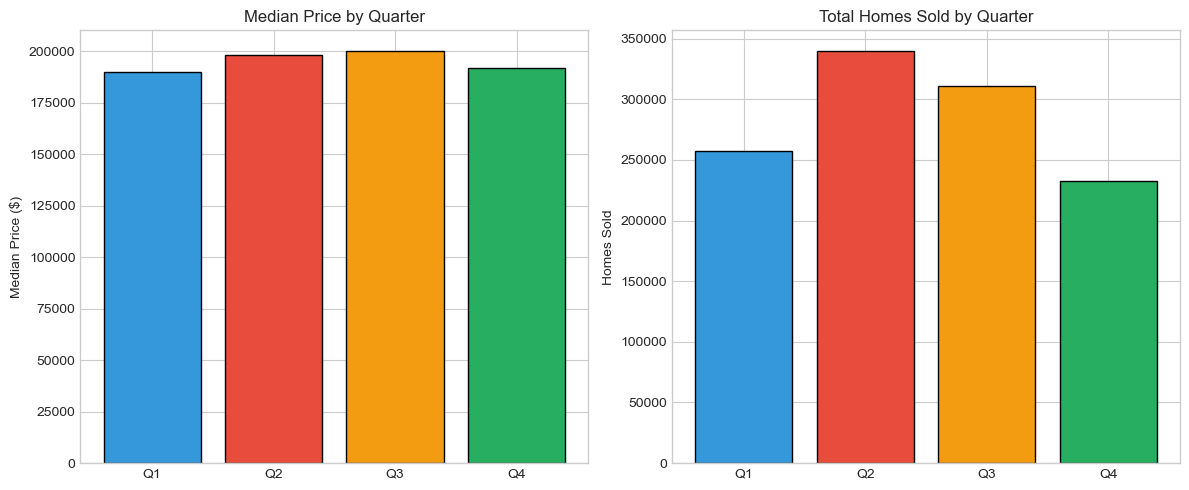

Peak price quarter:  Q3 ($200,000)
Peak volume quarter: Q2 (339,754 homes)


In [56]:
# === SEASONALITY ===

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

seasonal_price = df.groupby('quarter')['median_sale_price'].median()
seasonal_volume = df.groupby('quarter')['homes_sold'].sum()

colors = ['#3498db', '#e74c3c', '#f39c12', '#27ae60']

axes[0].bar(['Q1', 'Q2', 'Q3', 'Q4'], seasonal_price.values, color=colors, edgecolor='black')
axes[0].set_title('Median Price by Quarter')
axes[0].set_ylabel('Median Price ($)')

axes[1].bar(['Q1', 'Q2', 'Q3', 'Q4'], seasonal_volume.values, color=colors, edgecolor='black')
axes[1].set_title('Total Homes Sold by Quarter')
axes[1].set_ylabel('Homes Sold')

plt.tight_layout()
plt.show()

print(f"Peak price quarter:  Q{seasonal_price.idxmax()} (${seasonal_price.max():,.0f})")
print(f"Peak volume quarter: Q{seasonal_volume.idxmax()} ({seasonal_volume.max():,} homes)")


 **Seasonality Insight:** Q2-Q3 (Spring/Summer) shows highest activity and prices,

 while Q4-Q1 (Fall/Winter) is slower. We encode quarter as a feature to capture this.

 ### 3.6 Geographic Analysis



 The Charlotte metro spans multiple zip codes across NC and SC, with significant

 variation in prices and market dynamics.

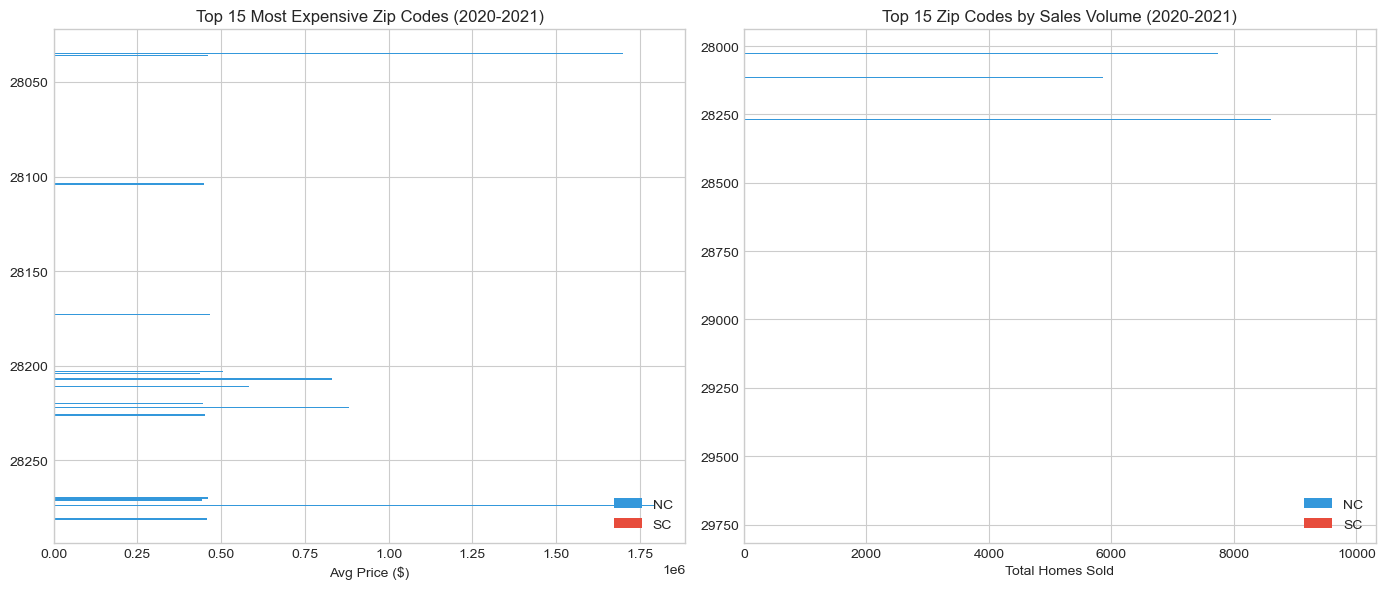


📍 NC vs SC Comparison (2020-2021):
            Avg Price  Total Sold  Zip Codes
state_code                                  
NC         299,033.00      239518        103
SC         247,315.00       45706         22


In [57]:
# === GEOGRAPHIC ANALYSIS (2020-2021) ===

recent = df[df['year'] >= 2020]

zip_stats = recent.groupby('region').agg({
    'median_sale_price': 'mean',
    'homes_sold': 'sum',
    'median_dom': 'mean',
    'sold_above_list': 'mean',
    'state_code': 'first'
}).round(2)
zip_stats.columns = ['avg_price', 'total_sold', 'avg_dom', 'pct_above_list', 'state']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Top 15 most expensive
top_15 = zip_stats.sort_values('avg_price', ascending=False).head(15)
colors = ['#3498db' if s == 'NC' else '#e74c3c' for s in top_15['state']]
axes[0].barh(top_15.index, top_15['avg_price'], color=colors)
axes[0].set_title('Top 15 Most Expensive Zip Codes (2020-2021)')
axes[0].set_xlabel('Avg Price ($)')
axes[0].invert_yaxis()

# Top 15 by volume
by_volume = zip_stats.sort_values('total_sold', ascending=False).head(15)
colors = ['#3498db' if s == 'NC' else '#e74c3c' for s in by_volume['state']]
axes[1].barh(by_volume.index, by_volume['total_sold'], color=colors)
axes[1].set_title('Top 15 Zip Codes by Sales Volume (2020-2021)')
axes[1].set_xlabel('Total Homes Sold')
axes[1].invert_yaxis()

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#3498db', label='NC'), Patch(facecolor='#e74c3c', label='SC')]
for ax in axes:
    ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

# State comparison
print("\n📍 NC vs SC Comparison (2020-2021):")
state_comp = recent.groupby('state_code').agg({
    'median_sale_price': 'mean',
    'homes_sold': 'sum',
    'region': 'nunique'
}).round(0)
state_comp.columns = ['Avg Price', 'Total Sold', 'Zip Codes']
print(state_comp)


 ### 3.7 Feature Correlations



 Understanding feature correlations helps identify multicollinearity issues

 and reveals which features most strongly predict price.

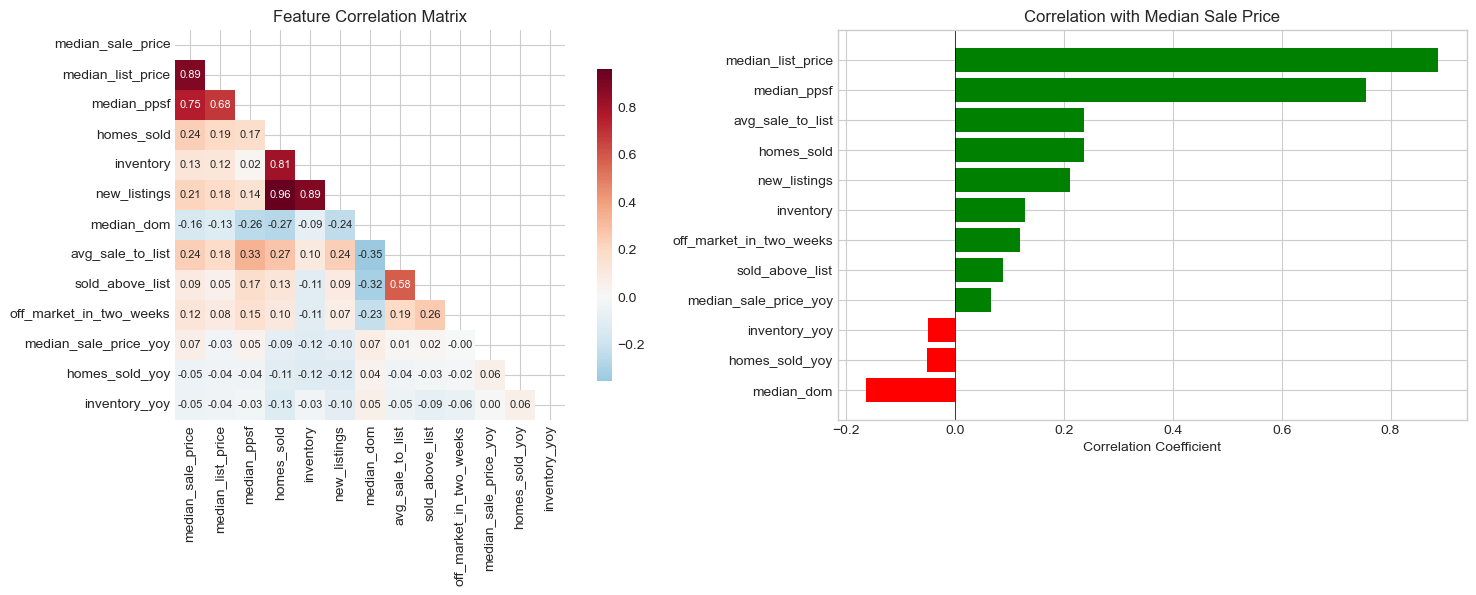

Top positive correlations: {'avg_sale_to_list': 0.23673834122198992, 'median_ppsf': 0.7549708276230936, 'median_list_price': 0.8873756938547935}
Top negative correlations: {'median_dom': -0.16337405813902206, 'homes_sold_yoy': -0.0514020649816881, 'inventory_yoy': -0.0504630715972726}


In [58]:
# === CORRELATION ANALYSIS ===

num_features = [
    'median_sale_price', 'median_list_price', 'median_ppsf',
    'homes_sold', 'inventory', 'new_listings',
    'median_dom', 'avg_sale_to_list', 'sold_above_list',
    'off_market_in_two_weeks',
    'median_sale_price_yoy', 'homes_sold_yoy', 'inventory_yoy'
]

corr_matrix = df[num_features].corr()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            fmt='.2f', square=True, ax=axes[0], cbar_kws={'shrink': 0.8}, annot_kws={'size': 8})
axes[0].set_title('Feature Correlation Matrix')

# Correlation with target
target_corr = corr_matrix['median_sale_price'].drop('median_sale_price').sort_values()
colors = ['green' if x > 0 else 'red' for x in target_corr.values]
axes[1].barh(target_corr.index, target_corr.values, color=colors)
axes[1].set_title('Correlation with Median Sale Price')
axes[1].set_xlabel('Correlation Coefficient')
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

print("Top positive correlations:", target_corr.tail(3).to_dict())
print("Top negative correlations:", target_corr.head(3).to_dict())


 **Critical Finding:** `median_list_price` (r=0.89) and `median_ppsf` (r=0.75) are

 highly correlated with `median_sale_price`. These are **data leakage** risks since

 they're essentially proxies for the target. We will remove them before modeling.

 ### 3.8 Market Phase Classification



 To provide actionable investment signals, we create a derived feature that

 classifies each market observation as HOT, COLD, or STABLE based on multiple indicators.

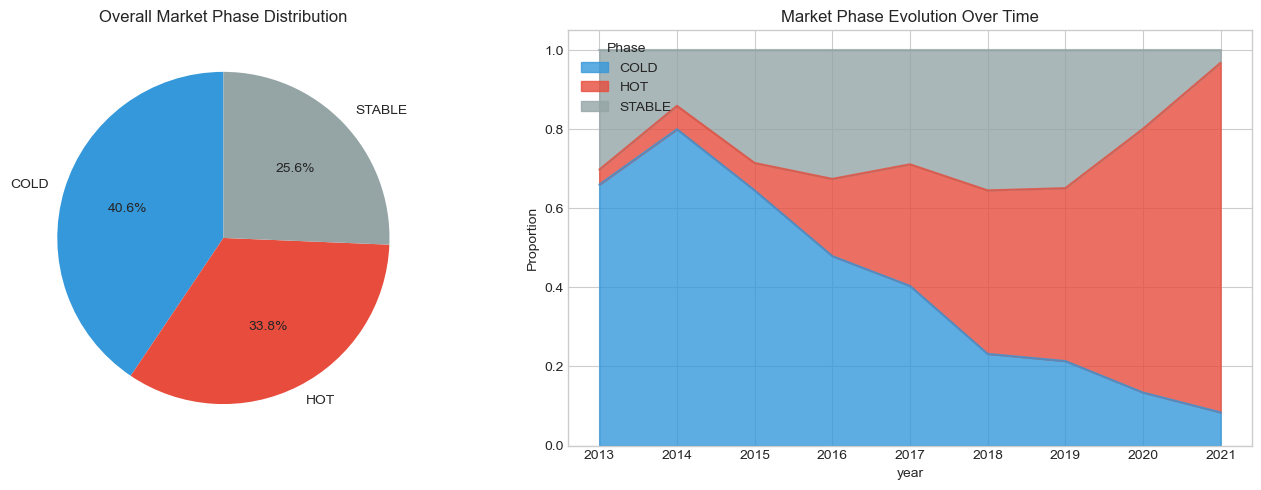


Market Phase Distribution:
market_phase
COLD      4774
HOT       3974
STABLE    3017
Name: count, dtype: int64

Percentages:
market_phase
COLD     40.60
HOT      33.80
STABLE   25.60
Name: count, dtype: float64


In [59]:
# === MARKET PHASE LABELING ===

def classify_market(row):
    """
    Classify market phase based on multiple indicators.
    HOT: Seller's market - high competition, fast sales, prices rising
    COLD: Buyer's market - low competition, slow sales, prices flat/falling
    STABLE: Balanced market
    """
    hot_signals = 0
    cold_signals = 0
    
    # HOT indicators
    if row['sold_above_list'] > 0.25: hot_signals += 1
    if row['median_dom'] < 50: hot_signals += 1
    if row['median_sale_price_yoy'] > 0.05: hot_signals += 1
    if row['off_market_in_two_weeks'] > 0.35: hot_signals += 1
    
    # COLD indicators
    if row['sold_above_list'] < 0.10: cold_signals += 1
    if row['median_dom'] > 90: cold_signals += 1
    if row['median_sale_price_yoy'] < 0: cold_signals += 1
    if row['off_market_in_two_weeks'] < 0.15: cold_signals += 1
    
    if hot_signals >= 2: return 'HOT'
    elif cold_signals >= 2: return 'COLD'
    else: return 'STABLE'

df['market_phase'] = df.apply(classify_market, axis=1)

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

phase_counts = df['market_phase'].value_counts()
colors_pie = {'HOT': '#e74c3c', 'STABLE': '#95a5a6', 'COLD': '#3498db'}

# Pie chart
axes[0].pie(phase_counts.values, labels=phase_counts.index, autopct='%1.1f%%',
            colors=[colors_pie[p] for p in phase_counts.index], startangle=90)
axes[0].set_title('Overall Market Phase Distribution')

# Evolution over time
phase_time = df.groupby(['year', 'market_phase']).size().unstack(fill_value=0)
phase_time_pct = phase_time.div(phase_time.sum(axis=1), axis=0)
phase_time_pct.plot(kind='area', stacked=True, ax=axes[1],
                    color=[colors_pie.get(c, 'gray') for c in phase_time_pct.columns], alpha=0.8)
axes[1].set_title('Market Phase Evolution Over Time')
axes[1].set_ylabel('Proportion')
axes[1].legend(title='Phase', loc='upper left')

plt.tight_layout()
plt.show()

print(f"\nMarket Phase Distribution:")
print(phase_counts)
print(f"\nPercentages:")
print((phase_counts / len(df) * 100).round(1))


 **Key Insight:** The Charlotte market underwent a dramatic transformation:

 - **2013-2014:** 66-80% COLD (buyer's market, post-recession recovery)

 - **2017-2018:** Transition period, roughly balanced

 - **2020-2021:** 67-88% HOT (extreme seller's market, COVID-driven)



 This provides a rich classification target with clear business meaning.

 ### 3.9 COVID-19 Impact Analysis



 The pandemic fundamentally altered the housing market. We quantify this shift

 to understand how our models must adapt to regime changes.

In [60]:
# === COVID IMPACT COMPARISON ===

pre_covid = df[df['year'] == 2019]
covid = df[df['year'].isin([2020, 2021])]

comparison = pd.DataFrame({
    'Pre-COVID (2019)': [
        pre_covid['median_sale_price'].median(),
        pre_covid['homes_sold'].sum(),
        pre_covid['median_dom'].median(),
        pre_covid['sold_above_list'].mean() * 100,
        pre_covid['off_market_in_two_weeks'].mean() * 100
    ],
    'COVID Era (2020-2021)': [
        covid['median_sale_price'].median(),
        covid['homes_sold'].sum(),
        covid['median_dom'].median(),
        covid['sold_above_list'].mean() * 100,
        covid['off_market_in_two_weeks'].mean() * 100
    ]
}, index=['Median Price ($)', 'Total Homes Sold', 'Days on Market', 
          '% Sold Above List', '% Off Market in 2 Weeks'])

comparison['% Change'] = ((comparison['COVID Era (2020-2021)'] - comparison['Pre-COVID (2019)']) / 
                           comparison['Pre-COVID (2019)'] * 100).round(1)

print("📊 COVID-19 IMPACT ANALYSIS:")
print(comparison.to_string())


📊 COVID-19 IMPACT ANALYSIS:
                         Pre-COVID (2019)  COVID Era (2020-2021)  % Change
Median Price ($)               215,000.00             265,000.00     23.30
Total Homes Sold               143,300.00             285,224.00     99.00
Days on Market                      57.50                  43.50    -24.30
% Sold Above List                   22.29                  37.54     68.50
% Off Market in 2 Weeks             20.75                  29.26     41.00


 **COVID Impact Summary:**

 - Prices jumped **+23%** ($215K → $265K)

 - Days on market dropped **-24%** (58 → 44 days)

 - Competition surged: **+68%** more homes sold above list price



 This justifies using 2020+ as our test set—it represents a fundamentally different market regime.

 ---

 ## 4. Pre-Processing for Modeling



 With EDA complete, we now prepare the data for our three modeling tracks:

 1. **Regression** (price prediction)

 2. **Classification** (market phase detection)

 3. **LSTM** (time series forecasting)

 ### 4.1 Feature Engineering



 Based on our EDA findings, we apply the following transformations:

In [61]:
# === FEATURE ENGINEERING ===

# Save cleaned data first
df.to_csv('charlotte_cleaned_data.csv', index=False)

# Reload for preprocessing
df = pd.read_csv('charlotte_cleaned_data.csv')

# 1. Log-transform target (addresses right skew)
df['log_price'] = np.log(df['median_sale_price'])

# 2. Remove data leakage features (too correlated with target)
leakage_features = [
    'median_list_price',
    'median_ppsf',
    'median_sale_price_mom',   # computed FROM target
    'median_sale_price_yoy',   # computed FROM target
    'avg_sale_to_list',        # same-period sales data
    'sold_above_list',         # same-period sales data
]
df = df.drop(columns=leakage_features)
print(f"Removed leakage features: {leakage_features}")

# 3. Remove multicollinear features
multicollinear_drop = ['new_listings', 'new_listings_mom', 'new_listings_yoy']
df = df.drop(columns=multicollinear_drop)
print(f"Removed multicollinear features: {multicollinear_drop}")

# 4. Add COVID era indicator
df['covid_era'] = (df['year'] >= 2020).astype(int)

# 5. Encode categorical features
df['state_NC'] = (df['state_code'] == 'NC').astype(int)
df = pd.get_dummies(df, columns=['quarter'], prefix='Q')

# 6. Encode market phase for classification
phase_map = {'COLD': 0, 'STABLE': 1, 'HOT': 2}
df['market_phase_encoded'] = df['market_phase'].map(phase_map)

# Save preprocessed data
df.to_csv('charlotte_preprocessed.csv', index=False)
print(f"\n✅ Preprocessed data saved: {df.shape[0]} rows, {df.shape[1]} columns")


Removed leakage features: ['median_list_price', 'median_ppsf', 'median_sale_price_mom', 'median_sale_price_yoy', 'avg_sale_to_list', 'sold_above_list']
Removed multicollinear features: ['new_listings', 'new_listings_mom', 'new_listings_yoy']

✅ Preprocessed data saved: 11765 rows, 27 columns


In [62]:
df.columns

Index(['period_begin', 'period_end', 'region', 'state_code',
       'median_sale_price', 'homes_sold', 'inventory', 'median_dom',
       'off_market_in_two_weeks', 'homes_sold_mom', 'homes_sold_yoy',
       'inventory_mom', 'inventory_yoy', 'median_dom_mom', 'median_dom_yoy',
       'year', 'quarter_label', 'year_quarter', 'market_phase', 'log_price',
       'covid_era', 'state_NC', 'Q_1', 'Q_2', 'Q_3', 'Q_4',
       'market_phase_encoded'],
      dtype='object')

 ### 4.2 Train/Test Split (Temporal)



 **Critical:** For time series data, we cannot use random splits. The test set

 must be chronologically after the training set to avoid data leakage.



 - **Training:** 2013-2019 (pre-COVID market conditions)

 - **Testing:** 2020-2021 (COVID era, tests model generalization)

In [63]:
# === TEMPORAL TRAIN/TEST SPLIT ===

TRAIN_END = 2019
TEST_START = 2020

train_df = df[df['year'] <= TRAIN_END].copy()
test_df = df[df['year'] >= TEST_START].copy()

print(f"Training Set: {len(train_df):,} rows (2013-{TRAIN_END})")
print(f"Test Set:     {len(test_df):,} rows ({TEST_START}-2021)")
print(f"Train/Test Ratio: {len(train_df)/len(df)*100:.1f}% / {len(test_df)/len(df)*100:.1f}%")


Training Set: 9,254 rows (2013-2019)
Test Set:     2,511 rows (2020-2021)
Train/Test Ratio: 78.7% / 21.3%


 ### 4.3 Feature Scaling



 Many algorithms (especially neural networks and regularized models) require

 features to be on similar scales. We use StandardScaler, fit only on training

 data to prevent information leakage.

In [64]:
# === FEATURE SCALING ===

# Define feature sets
regression_features = [
    'homes_sold', 'inventory', 'median_dom', 
    'off_market_in_two_weeks',
    'homes_sold_mom', 'homes_sold_yoy',
    'inventory_mom', 'inventory_yoy',
    'median_dom_mom', 'median_dom_yoy',
    'year', 'state_NC', 'covid_era',
    'Q_1', 'Q_2', 'Q_3', 'Q_4'
]

classification_features = [
    'homes_sold', 'inventory', 'median_dom',
    'off_market_in_two_weeks',
    'homes_sold_yoy', 'inventory_yoy', 'median_dom_yoy',
    'year', 'state_NC',
    'Q_1', 'Q_2', 'Q_3', 'Q_4'
]

# Continuous features to scale (not binary/encoded)
continuous_features = [
    'homes_sold', 'inventory', 'median_dom',
    'homes_sold_mom', 'homes_sold_yoy',
    'inventory_mom', 'inventory_yoy',
    'median_dom_mom', 'median_dom_yoy'
]

# Fit scaler on training data ONLY
scaler = StandardScaler()
train_df[continuous_features] = scaler.fit_transform(train_df[continuous_features])
test_df[continuous_features] = scaler.transform(test_df[continuous_features])

# Save scaler for future use
joblib.dump(scaler, 'scaler.pkl')
print(f"✅ Scaler fit on {len(continuous_features)} features, saved to scaler.pkl")


✅ Scaler fit on 9 features, saved to scaler.pkl


 ### 4.4 Class Weights for Imbalanced Classification



 Our market phase distribution is imbalanced (40% COLD, 34% HOT, 26% STABLE).

 We compute class weights to prevent the model from ignoring minority classes.

In [65]:
# === CLASS WEIGHTS ===

classes = np.array([0, 1, 2])
weights = compute_class_weight('balanced', classes=classes, y=train_df['market_phase_encoded'])
class_weight_dict = {int(k): float(v) for k, v in zip(classes, weights)}

print("Class Weights (to handle imbalance):")
print(f"  COLD (0):   {class_weight_dict[0]:.3f}")
print(f"  STABLE (1): {class_weight_dict[1]:.3f}")
print(f"  HOT (2):    {class_weight_dict[2]:.3f}")


Class Weights (to handle imbalance):
  COLD (0):   0.686
  STABLE (1): 1.138
  HOT (2):    1.505


 ### 4.5 Export Modeling Datasets



 We export separate, ready-to-use datasets for each modeling track, along with

 a configuration file documenting all settings.

In [66]:
# === EXPORT DATASETS ===

# Track 1: Regression
reg_cols = ['region', 'period_begin'] + regression_features + ['log_price', 'median_sale_price']
train_df[reg_cols].to_csv('regression_train.csv', index=False)
test_df[reg_cols].to_csv('regression_test.csv', index=False)

# Track 2: Classification
clf_cols = ['region', 'period_begin'] + classification_features + ['market_phase_encoded', 'market_phase']
train_df[clf_cols].to_csv('classification_train.csv', index=False)
test_df[clf_cols].to_csv('classification_test.csv', index=False)

# Track 3: LSTM (needs unscaled sequential data)
df_original = pd.read_csv('charlotte_preprocessed.csv')
time_coverage = df_original.groupby('region').size().reset_index(name='quarters')
complete_zips = time_coverage[time_coverage['quarters'] >= 30]['region'].tolist()

tsa_df = df_original[df_original['region'].isin(complete_zips)].copy()
tsa_df = tsa_df.sort_values(['region', 'period_begin'])
tsa_train = tsa_df[tsa_df['year'] <= TRAIN_END]
tsa_test = tsa_df[tsa_df['year'] >= TEST_START]
tsa_train.to_csv('tsa_train.csv', index=False)
tsa_test.to_csv('tsa_test.csv', index=False)

print("✅ Datasets exported:")
print(f"   regression_train.csv     ({len(train_df):,} rows)")
print(f"   regression_test.csv      ({len(test_df):,} rows)")
print(f"   classification_train.csv")
print(f"   classification_test.csv")
print(f"   tsa_train.csv            ({len(tsa_train):,} rows)")
print(f"   tsa_test.csv             ({len(tsa_test):,} rows)")

✅ Datasets exported:
   regression_train.csv     (9,254 rows)
   regression_test.csv      (2,511 rows)
   classification_train.csv
   classification_test.csv
   tsa_train.csv            (9,090 rows)
   tsa_test.csv             (2,443 rows)


 ### 4.6 Configuration File



 We export all settings to a JSON file so teammates can easily load the correct

 features and parameters without reviewing this notebook.

In [67]:
# === EXPORT CONFIGURATION ===

config = {
    'split': {
        'train_years': '2013-2019',
        'test_years': '2020-2021',
        'train_size': len(train_df),
        'test_size': len(test_df)
    },
    'regression': {
        'features': regression_features,
        'target': 'log_price',
        'target_original': 'median_sale_price',
        'scaled_features': continuous_features
    },
    'classification': {
        'features': classification_features,
        'target': 'market_phase_encoded',
        'classes': {'COLD': 0, 'STABLE': 1, 'HOT': 2},
        'class_weights': class_weight_dict
    },
    'lstm': {
        'file': 'lstm_timeseries.csv',
        'sequence_length': 4,
        'target': 'median_sale_price',
        'num_zips': len(complete_zips),
        'note': 'Data is UNSCALED - scale within LSTM pipeline'
    }
}

with open('model_config.json', 'w') as f:
    json.dump(config, f, indent=2)

print("✅ Configuration saved to model_config.json")
print("\nConfig preview:")
print(json.dumps(config['split'], indent=2))


✅ Configuration saved to model_config.json

Config preview:
{
  "train_years": "2013-2019",
  "test_years": "2020-2021",
  "train_size": 9254,
  "test_size": 2511
}


 ---

 ## 5. Summary: Ready for Modeling



 ### Files Created



 | File | Purpose | Rows |

 |------|---------|------|

 | `regression_train.csv` | Training data for price prediction | 9,254 |

 | `regression_test.csv` | Test data for price prediction | 2,511 |

 | `classification_train.csv` | Training data for market phase | 9,254 |

 | `classification_test.csv` | Test data for market phase | 2,511 |

 | `lstm_timeseries.csv` | Sequential data for LSTM | 11,533 |

 | `scaler.pkl` | Fitted StandardScaler | - |

 | `model_config.json` | Feature lists and settings | - |



 ### Next Steps



 Each team member can now proceed with their assigned modeling track:



 1. **Regression Team:** Load `regression_train.csv`, predict `log_price`

 2. **Classification Team:** Load `classification_train.csv`, predict `market_phase_encoded`

 3. **LSTM Team:** Load `lstm_timeseries.csv`, create sequences, forecast prices



 See `Modeling Quick Start Guide.md` for detailed instructions.

 ---

 *End of EDA and Preprocessing Notebook*

In [ ]:
# delete unnecessar y files
import os
os.remove("charlotte_data.csv")
os.remove("charlotte_cleaned_data.csv")
os.remove("charlotte_preprocessed.csv")